In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
import os
import re

In [ ]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [3]:
random_seed = 42
early_stopping_round = 100

In [7]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [8]:
filename_features = "features.csv"
filename_target = "target-7_8125.csv"

In [59]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(1872, 8) (1872, 4)
(1100, 8) (1100, 4)
(10780, 8) (10780, 4)


((13752, 8), (13752, 4))

## EDA

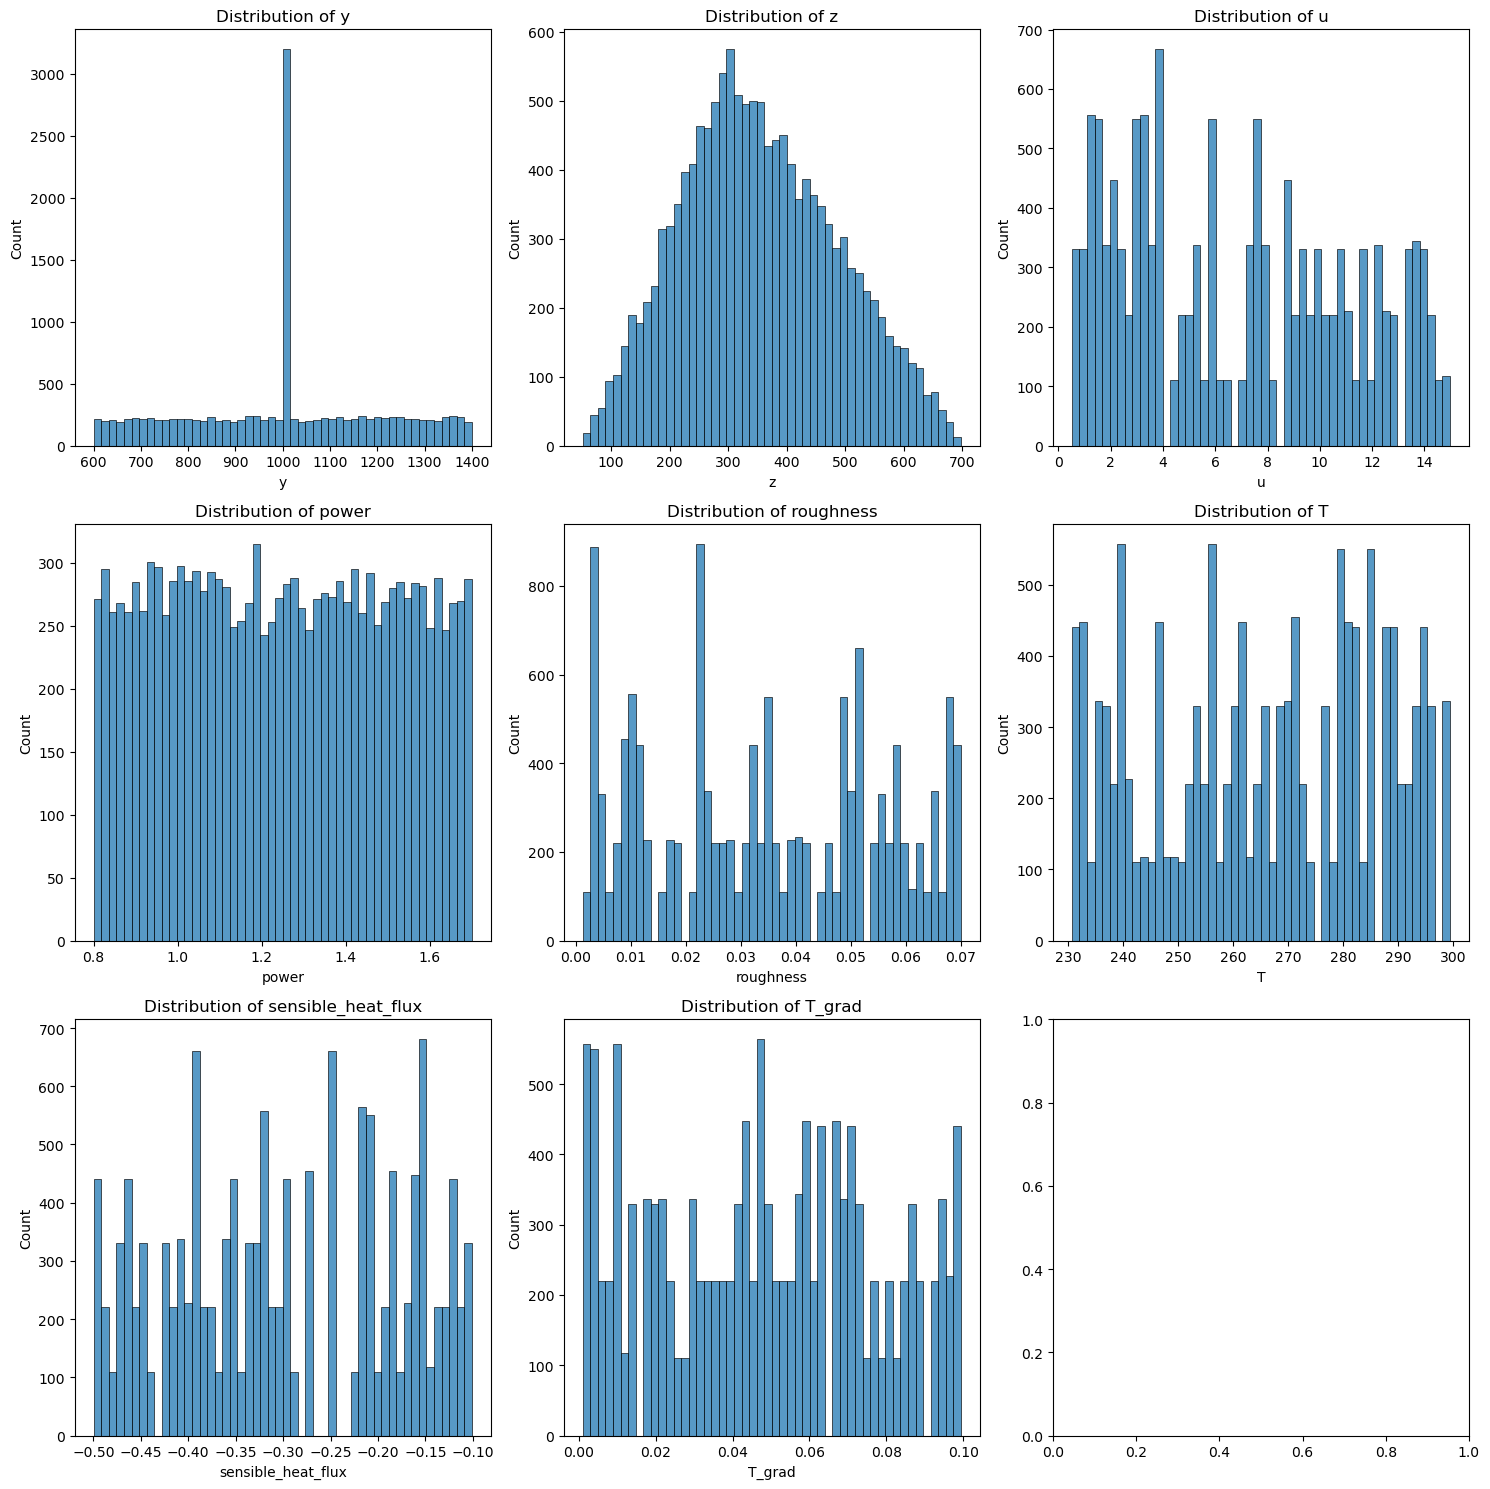

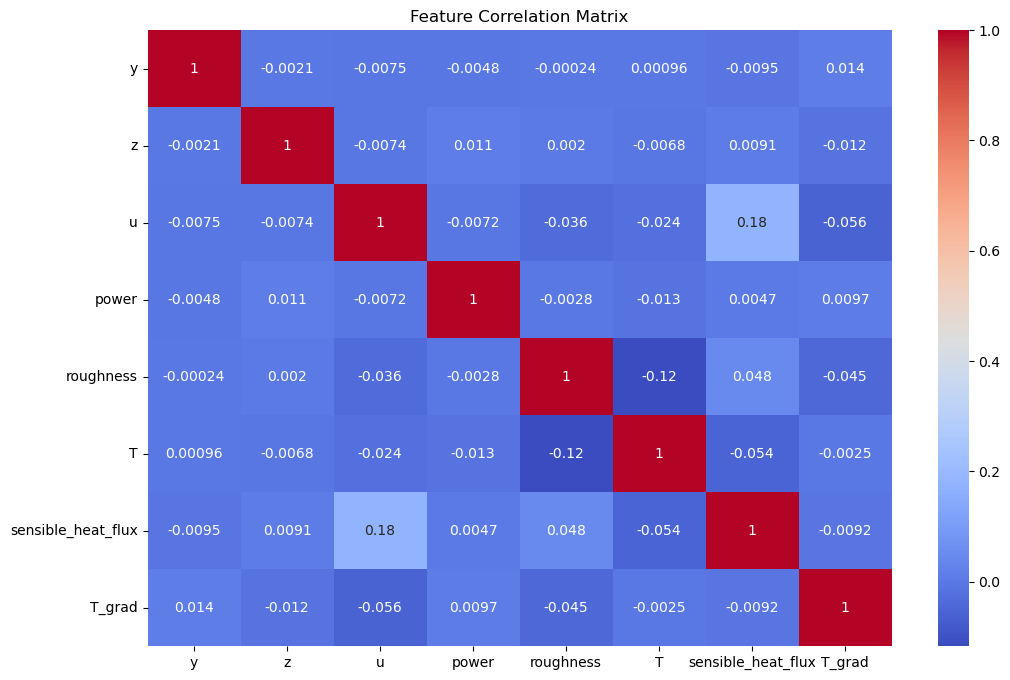

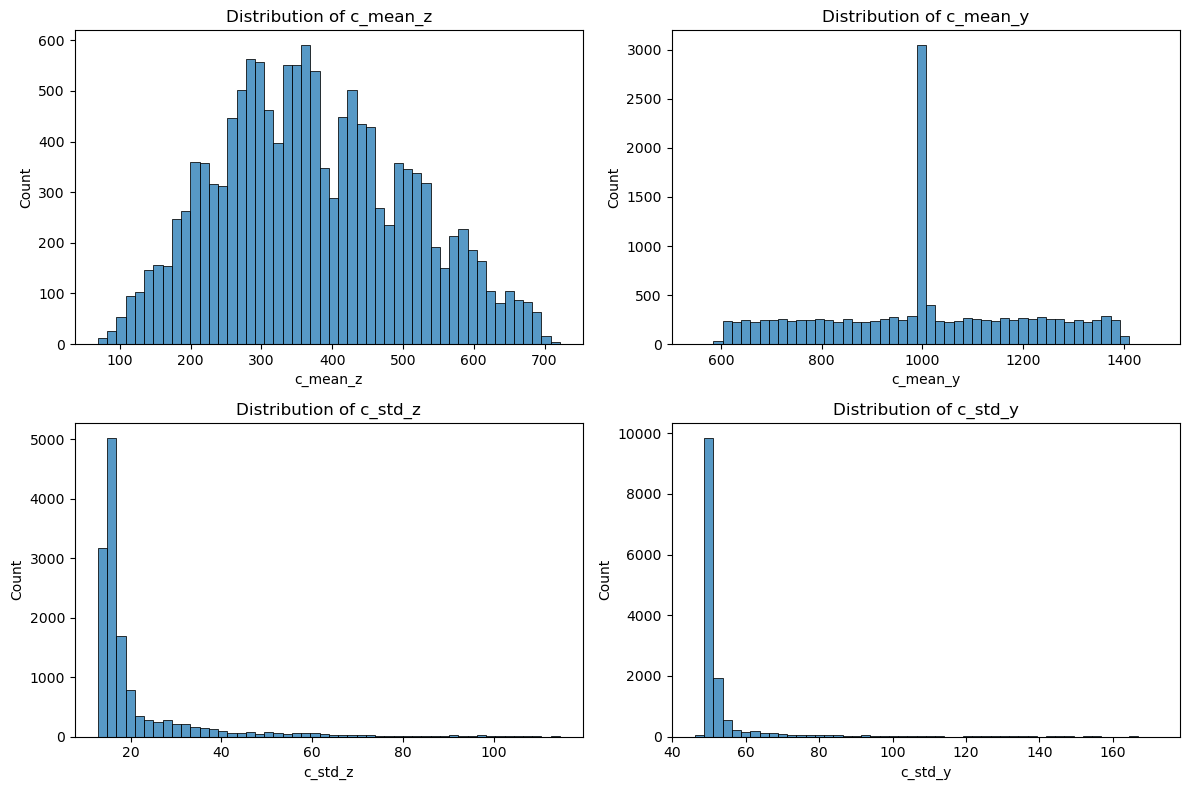

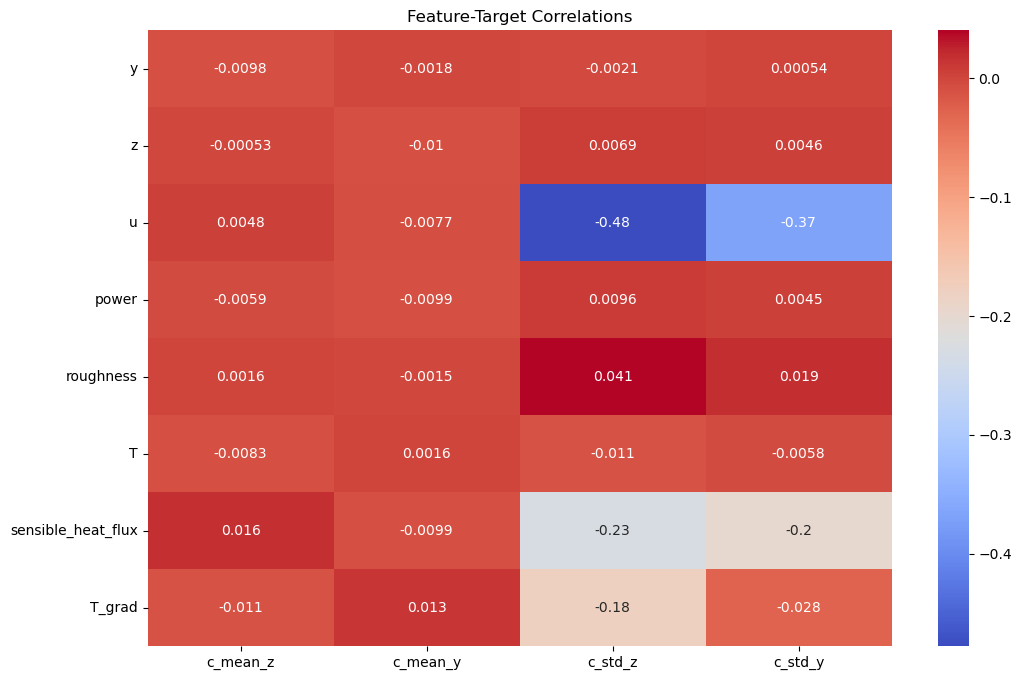

In [10]:
perform_eda(X, y)

## Feature engineering

In [58]:
y["c_mean_y"]-=X["y"]
y["c_mean_z"]-=X["z"]

y["c_mean_y"] = (y["c_mean_y"] - np.mean(y["c_mean_y"]))/(np.std(y["c_mean_y"]))
y["c_mean_z"] = (y["c_mean_z"] - np.mean(y["c_mean_z"]))/(np.std(y["c_mean_z"]))


## Test-train split

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [60]:
# for small dataset
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [61]:
# for small dataset
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((9900, 8), (9900, 4), (1101, 8), (1101, 4))

In [14]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (165581, 9), (165581, 4), (66233, 9), (66233, 4))

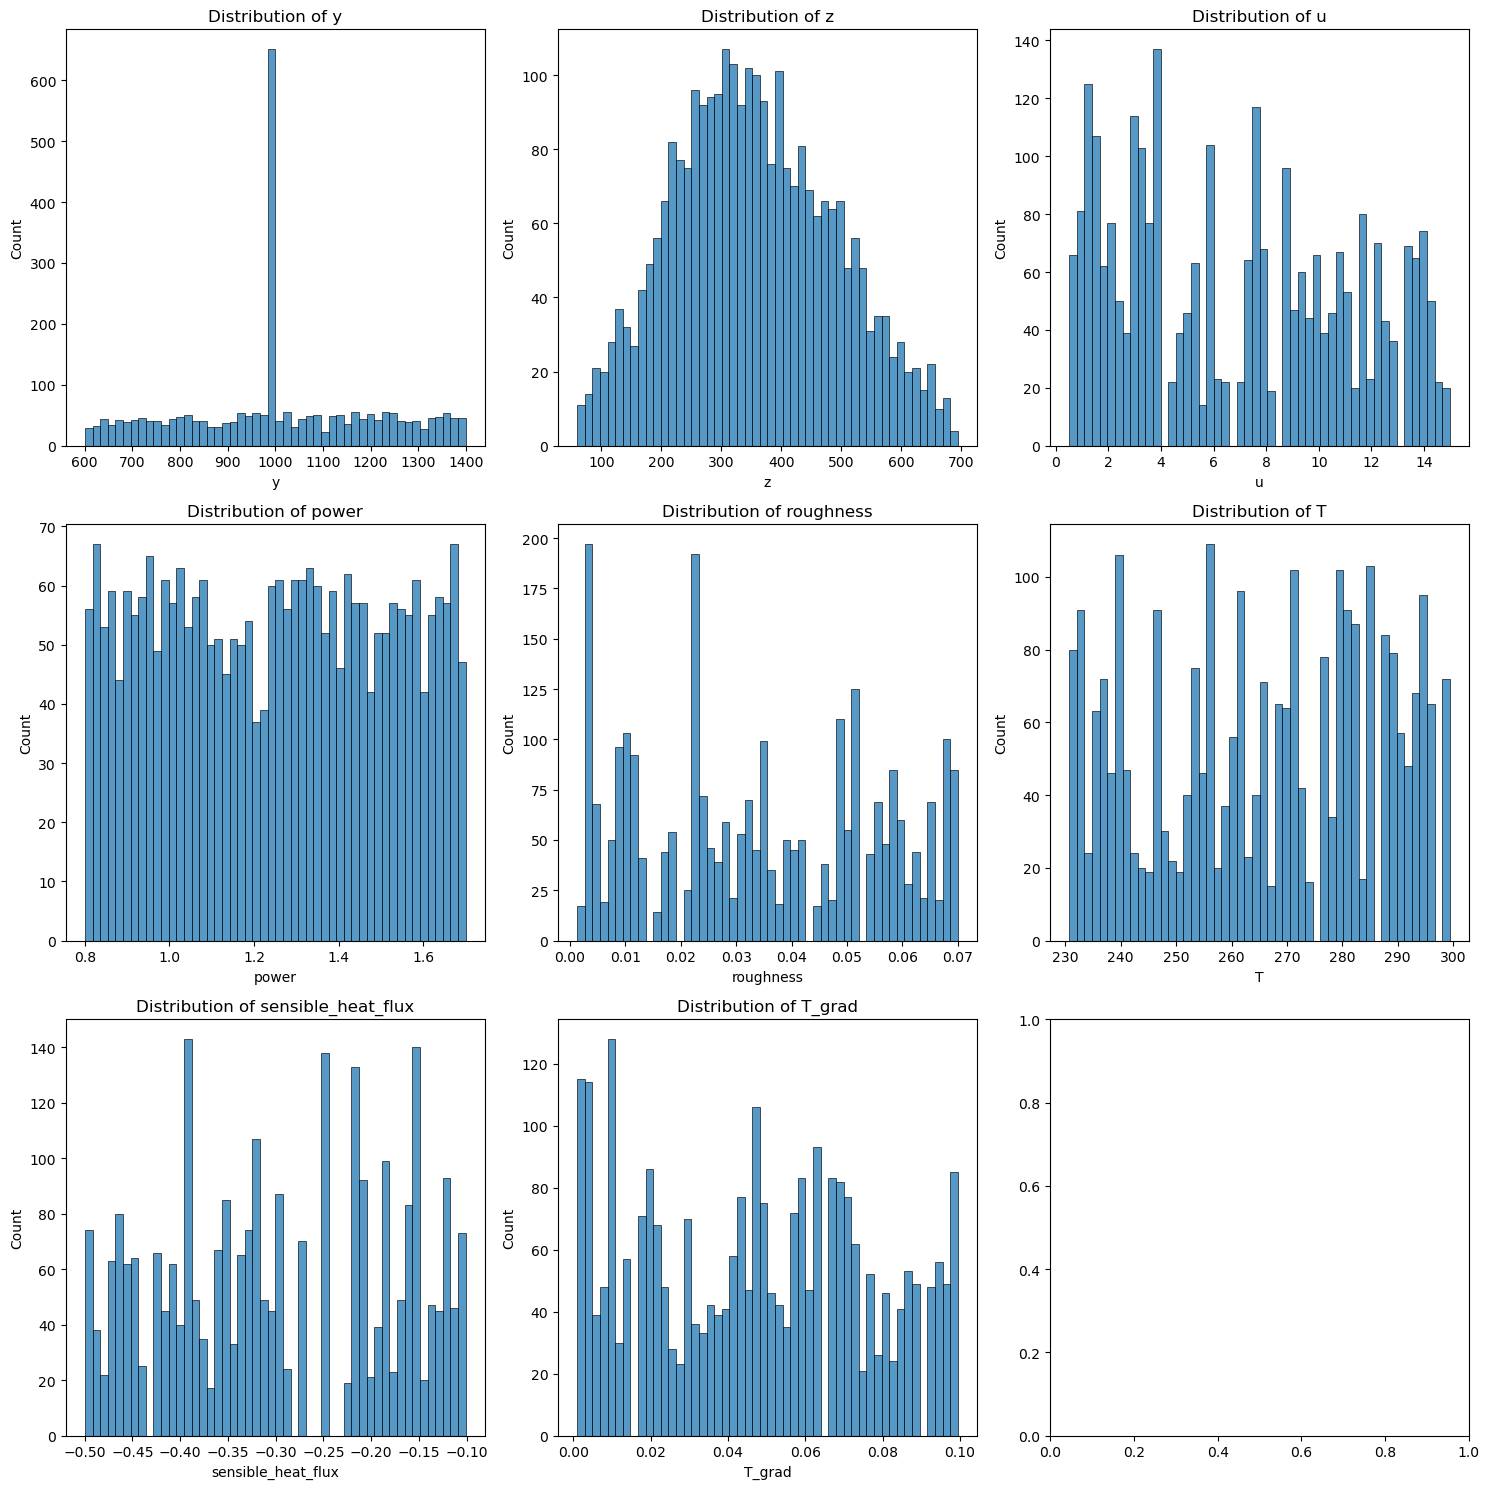

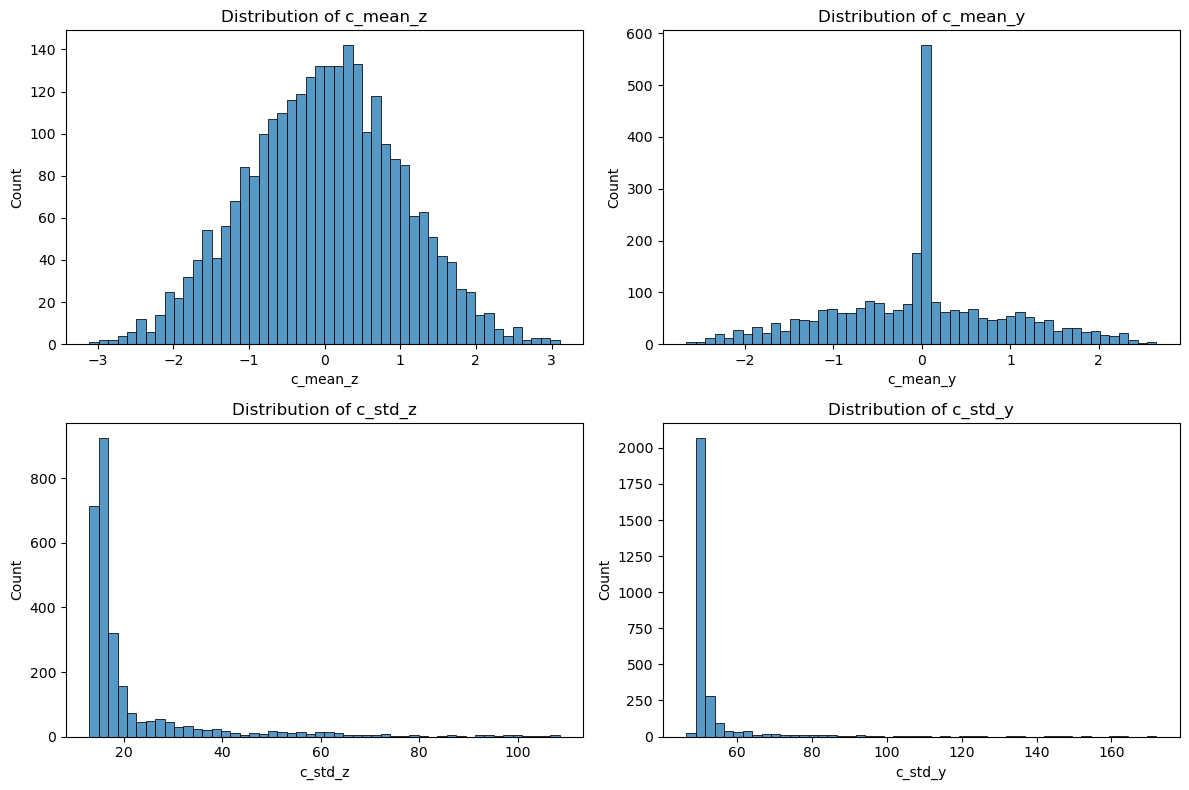

In [48]:
perform_eda_short(X_test, y_test)

## Feature engineering

In [62]:
#Train Mean Standartization
y_train["c_mean_y"]-=X_train["y"]
y_train["c_mean_z"]-=X_train["z"]

y_train["c_mean_y"] = (y_train["c_mean_y"] - np.mean(y_train["c_mean_y"]))/(np.std(y_train["c_mean_y"]))
y_train["c_mean_z"] = (y_train["c_mean_z"] - np.mean(y_train["c_mean_z"]))/(np.std(y_train["c_mean_z"]))

In [ ]:
# Test Mean Standartization
y_test["c_mean_y"]-=X_test["y"]
y_test["c_mean_z"]-=X_test["z"]

y_test["c_mean_y"] = (y_test["c_mean_y"] - np.mean(y_test["c_mean_y"]))/(np.std(y_test["c_mean_y"]))
y_test["c_mean_z"] = (y_test["c_mean_z"] - np.mean(y_test["c_mean_z"]))/(np.std(y_test["c_mean_z"]))

In [ ]:
# Test Mean Standartization
y_test["c_mean_y"]-=X_test["y"]
y_test["c_mean_z"]-=X_test["z"]

y_test["c_mean_y"] = (y_test["c_mean_y"] - np.mean(y_test["c_mean_y"]))/(np.std(y_test["c_mean_y"]))
y_test["c_mean_z"] = (y_test["c_mean_z"] - np.mean(y_test["c_mean_z"]))/(np.std(y_test["c_mean_z"]))

In [ ]:
# Train feature Standartization
X_train["y"]=(X_train["y"] - np.mean(X_train["y"]))/(np.std(X_train["y"]))
X_train["z"]=(X_train["z"] - np.mean(X_train["z"]))/(np.std(X_train["z"]))

In [ ]:
#Delete zeros in train
X_train = X_train[y_train["c_std_y"] != 0]
X_train = X_train[y_train["c_std_z"] != 0]

y_train = y_train[y_train["c_std_z"] != 0]
y_train = y_train[y_train["c_std_y"] != 0]

In [ ]:
#Train std logarighm
y_train["c_std_y"] = np.log(y_train["c_std_y"])
y_train["c_std_z"] = np.log(y_train["c_std_z"])

In [ ]:
#Delete zeros in test
X_test = X_test[y_test["c_std_y"] != 0]
X_test = X_test[y_test["c_std_z"] != 0]

y_test = y_test[y_test["c_std_z"] != 0]
y_test = y_test[y_test["c_std_y"] != 0]

In [ ]:
#Test std logarighm
y_test["c_std_y"] = np.log(y_test["c_std_y"])
y_test["c_std_z"] = np.log(y_test["c_std_z"])

## Models

### Constant model

In [48]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.mean(y_train[target]) * np.ones(len(y_test[target]))

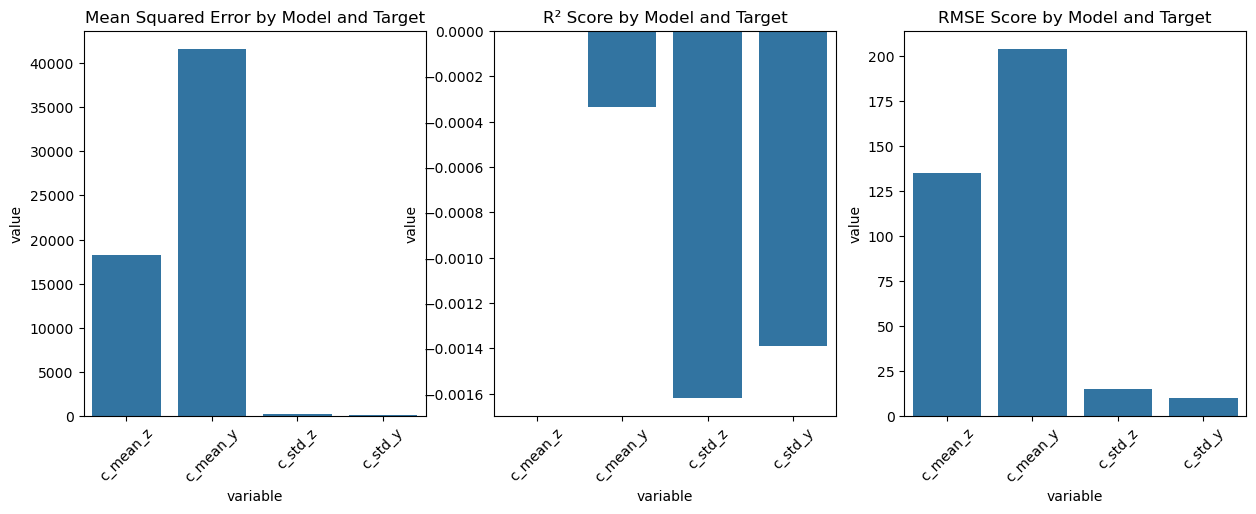

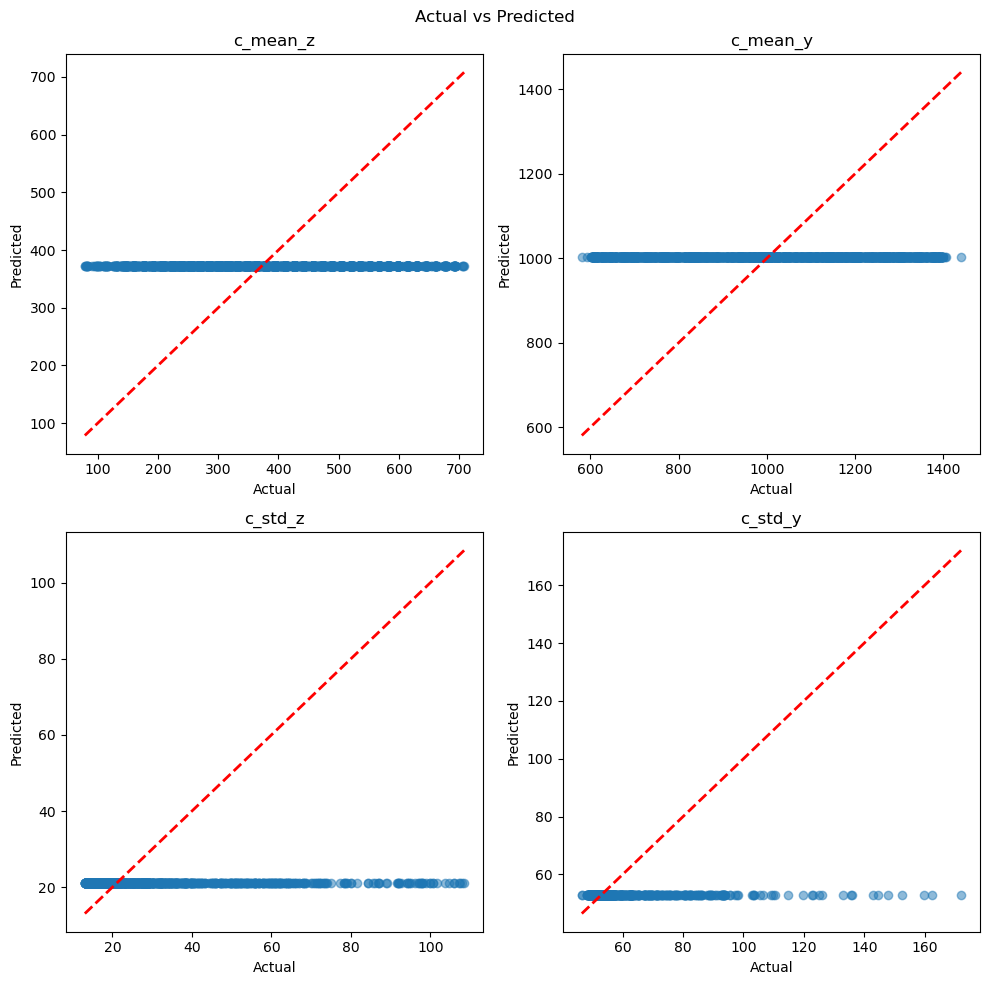

                   mse        r2        rmse
c_mean_z  18189.403996 -0.000003  134.868099
c_mean_y  41588.448847 -0.000335  203.932461
c_std_z     215.977415 -0.001617   14.696170
c_std_y     100.200285 -0.001392   10.010009


In [49]:
performance_visualizations(y_pred, y_test)

### Random model

In [50]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.random.normal(np.min(y_train[target]), np.max(y_train[target]), len(y_test))

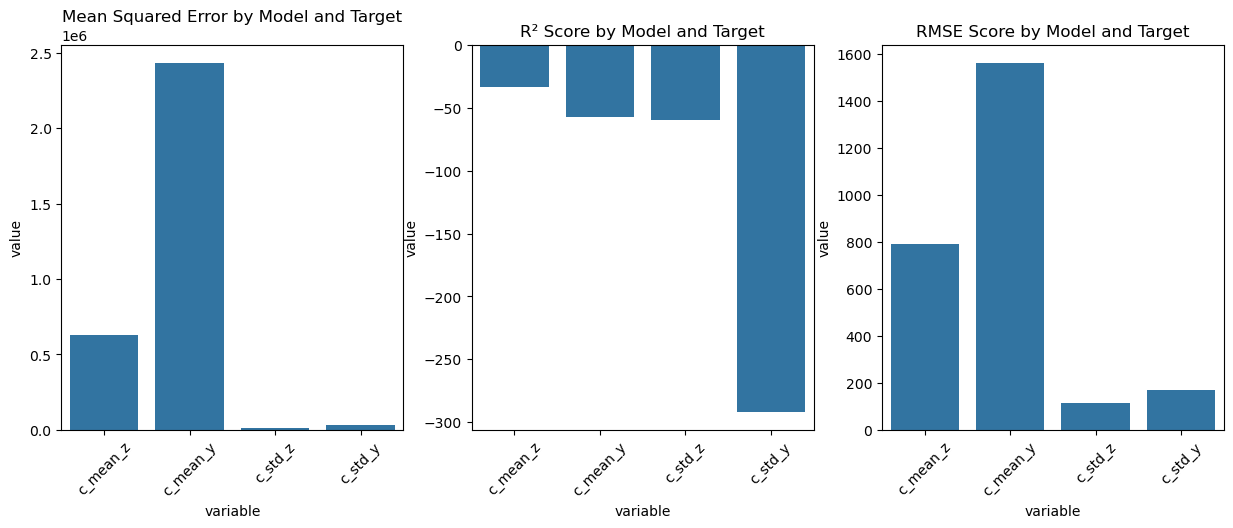

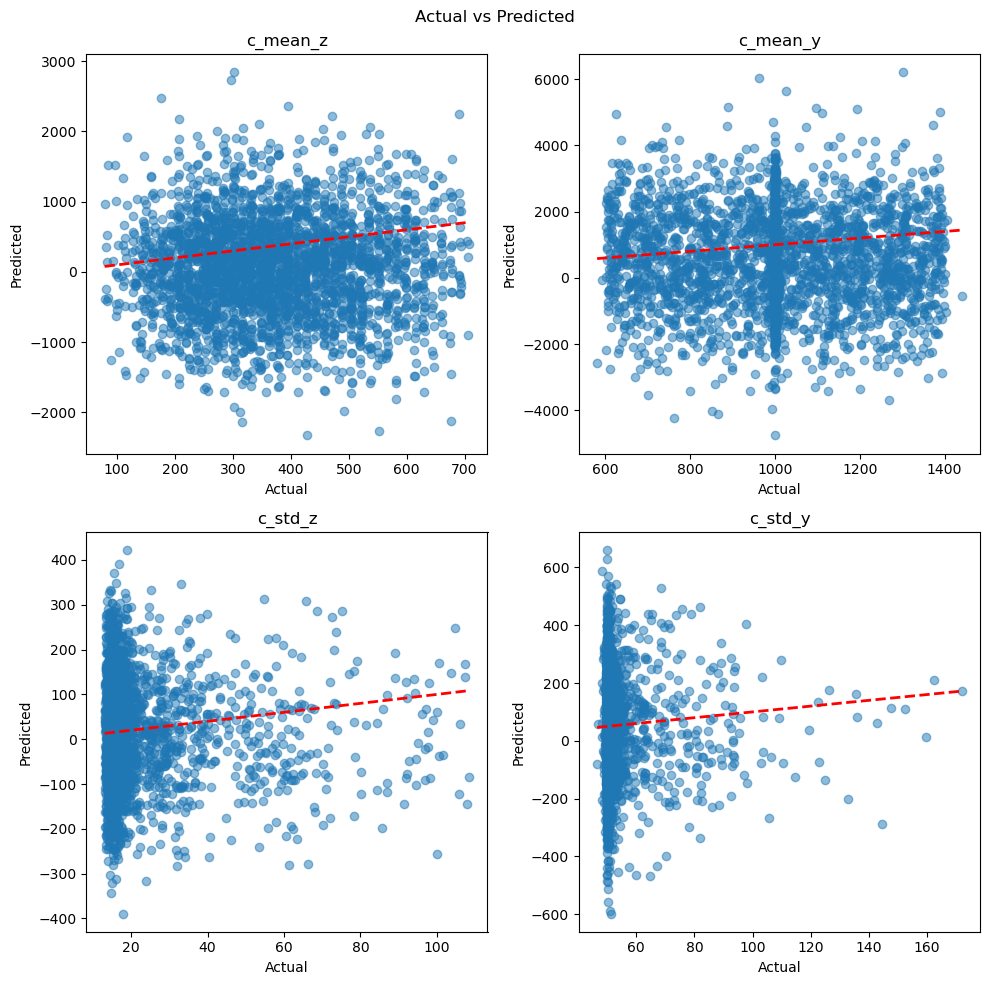

                   mse          r2         rmse
c_mean_z  6.264649e+05  -33.441309   791.495340
c_mean_y  2.430873e+06  -57.470230  1559.125658
c_std_z   1.307899e+04  -59.655154   114.363410
c_std_y   2.926869e+04 -291.508388   171.080933


In [51]:
performance_visualizations(y_pred, y_test)

## Catboost with optuna

In [39]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        # 'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=7200)

In [19]:
print(study.best_value)
print(study.best_params)

100.47450952063343
{'learning_rate': 0.012222773725010277, 'depth': 9, 'l2_leaf_reg': 2.48001112979733, 'min_child_samples': 8}


In [40]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 4}

In [63]:
%%time
y_pred ={}
for target in y_train.columns:
    
    optimized_regressor = CatBoostRegressor(learning_rate=best_params['learning_rate'],
                                            depth=best_params['depth'],
                                            l2_leaf_reg=best_params['l2_leaf_reg'],
                                            min_child_samples=best_params['min_child_samples'],
                                            grow_policy='Depthwise',
                                            iterations=500,
                                            use_best_model=True,
                                            eval_metric='RMSE',
                                            loss_function= 'RMSE',
                                            thread_count = -1,
                                            od_type='iter',
                                            od_wait=20,
                                            random_state=random_seed,
                                            logging_level='Silent')
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 

CPU times: user 29min 44s, sys: 4min 14s, total: 33min 59s
Wall time: 17.2 s


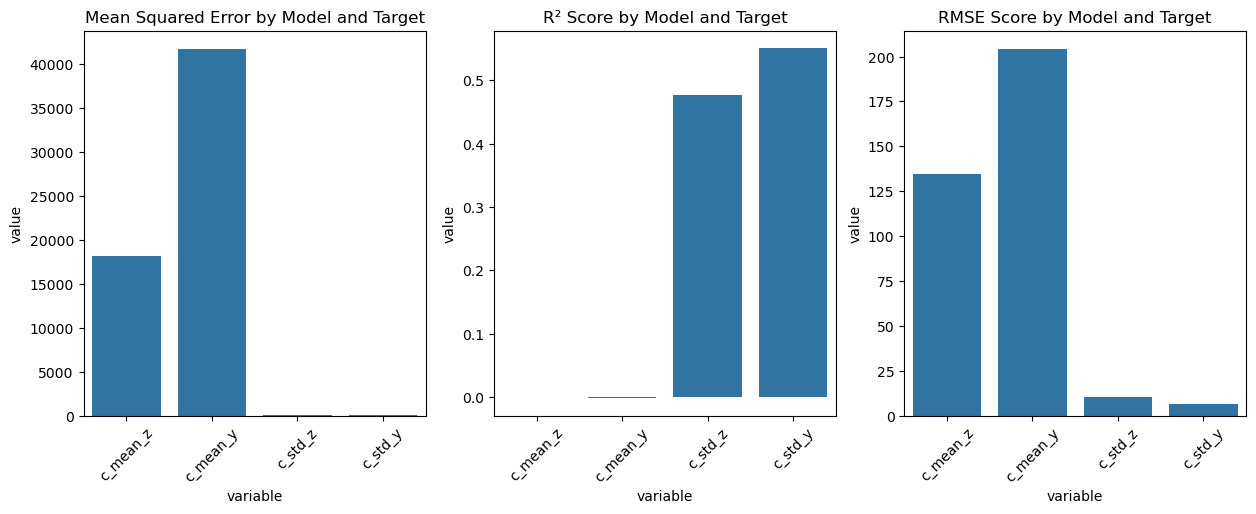

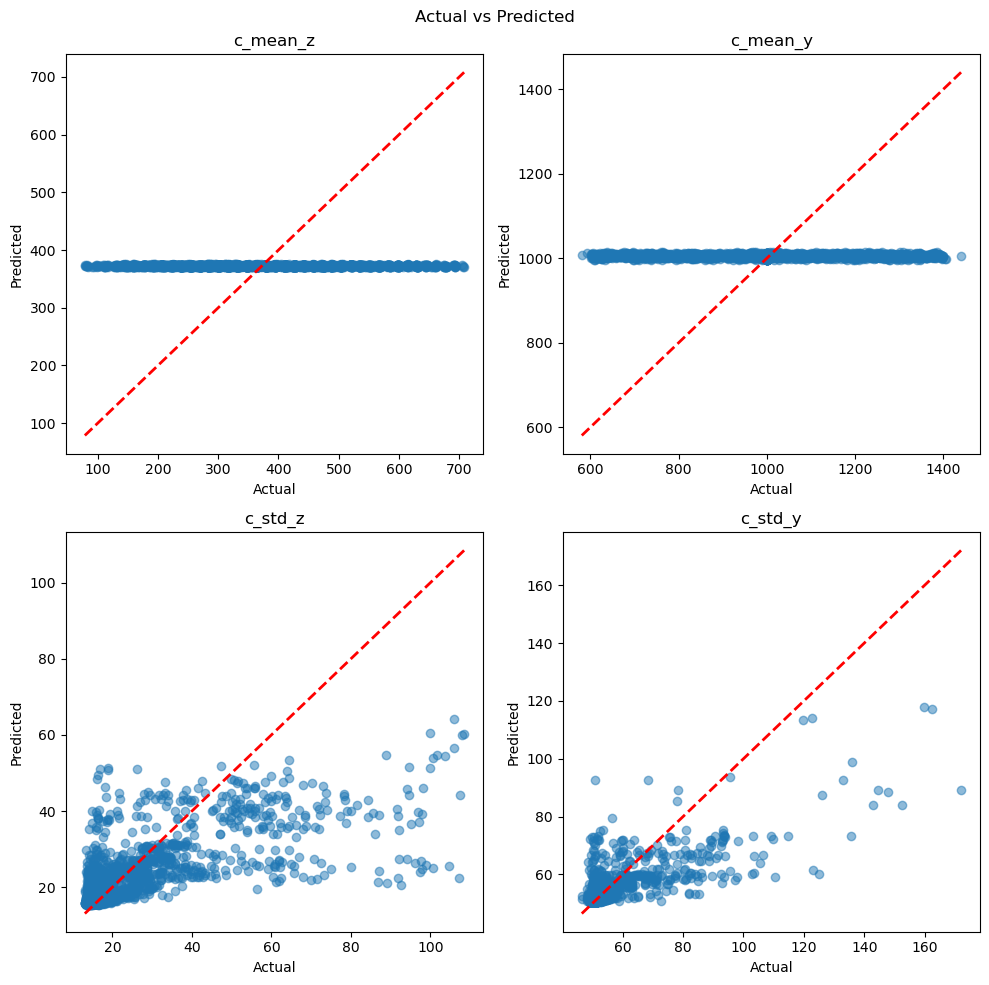

                   mse        r2        rmse
c_mean_z  18194.840691 -0.000302  134.888253
c_mean_y  41663.149604 -0.002131  204.115530
c_std_z     112.935870  0.476248   10.627129
c_std_y      45.000925  0.550265    6.708273


In [64]:
performance_visualizations(y_pred, y_test)